# Introduction: linear regression

This notebook is an introduction to the probabilistic modelling (PM) workflow for building energy use prediction.

It is also an introduction to PyMC, the easiest library to get started with PM in Python. More advanced users may want to try Stan as well, which is covered in [the book related to this notebook](https://buildingenergygeeks.org/). PyMC integrates well with ArviZ, a library for visualizations and diagnostics of Bayesian models.

For this first tutorial, we are only considering simple linear regression models. The later tutorials in the series show that the same Bayesian methodology can be followed regardless of model complexity.

## The data

The data used in this example was published by the Oak Ridge National Laboratory, Building Technologies Research and Integration Center (USA). It contains end use breakdowns of energy use and various indoor environmental conditions collected at the Campbell Creek Research House #3, at a 15 minute time stamp. The data availability ranges from 10/1/2013 to 9/30/2014. It is available for download at this address:

https://openei.org/datasets/dataset/ornl-research-house-3

This dataset was chosen in this example for the diversity and duration of the available measurements.

Before taking a look at the data, let us start with some imports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

Opening and displaying the data:

In [2]:
# Opening the data file and showing the timestamps to pandas
df = pd.read_csv('data/linearregression.csv')
df.set_index(pd.to_datetime(df['TIMESTAMP']), inplace=True, drop=True)

# Dealing with missing values
df.replace('NAN', np.nan, inplace=True)
df.ffill(inplace=True)

df.head()

,TIMESTAMP,e_hp,e_dhw,e_fan,e_other,ti,tg,ts,te,i_sol,wind_speed
TIMESTAMP,,,,,,,,,,,
2013-11-01,2013-11-01,22.765625,36.421875,9.866156,227.170302,24.089789,19.505035,12.687269,17.138426,125.659625,0.930979
2013-11-02,2013-11-02,22.942708,32.010417,9.985406,232.483344,22.716082,18.403356,8.639988,10.260706,90.866094,0.684573
2013-11-03,2013-11-03,23.072500,28.195000,9.977400,226.730100,21.181383,17.368833,10.676611,7.348556,113.592970,0.913760
2013-11-04,2013-11-04,49.602083,58.770833,10.032833,228.396333,20.667805,16.771181,11.524884,8.462442,116.153229,0.333625
2013-11-05,2013-11-05,23.098958,57.510417,10.008042,301.632583,20.979778,16.910417,11.532292,10.836343,108.980729,0.336969


This is only a subset of the original data, narrowed down to a daily resolution. The available data are:

* energy use of the heat pump, domestic hot water, fan consumption and other appliances
* temperatures: indoor, garage, ventilation supply and outdoor
* solar irradiance
* wind speed

We are going to use the **energy use of the heat pump** `e_hp` as the output variable of linear regression models, and try to explain it with the other available variables.

##  First simple model

In this first model, we will suppose that the energy use of the heat pump is a linear function of the heat transmission through the envelope and the solar irradiance:

$$ e_{hp} = \alpha + \beta_1 (T_i-T_e) + \beta_2 I_\mathit{sol} + \varepsilon $$

with $\varepsilon \sim N(0, \sigma)$. This is equivalent to writing:

$$ e_{hp} \sim \mathcal{N} \left( \alpha + \beta_1 (T_i-T_e) + \beta_2 I_\mathit{sol} \; , \sigma \right)$$

We are therefore looking for four parameters $(\alpha, \beta_1, \beta_2, \sigma)$.

The methodology below follows [PyMC's introductory overview](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html).

Text(0.5, 0, 'i_sol')

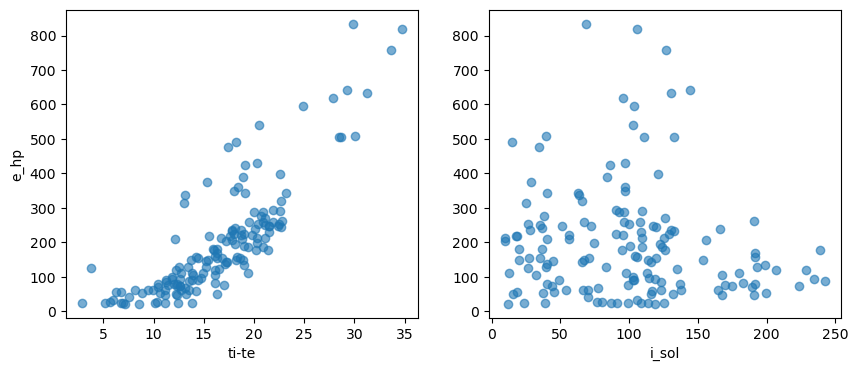

In [3]:
# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(df['ti'] - df['te'], df['e_hp'], alpha=0.6)
axes[1].scatter(df['i_sol'], df['e_hp'], alpha=0.6)
axes[0].set_ylabel("e_hp")
axes[0].set_xlabel("ti-te")
axes[1].set_xlabel("i_sol")

This is the model, written with PyMC:

In [4]:
Y = df['e_hp']
X1 = df['ti'] - df['te']
X2 = df['i_sol']

model1 = pm.Model()

with model1:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=[10, -1], sigma=[5, 1], shape=2)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

### Prior predictive sampling

The first three lines of the model above define prior distributions for each of the three parameters $(\alpha, \beta_1, \beta_2, \sigma)$. This step is optional but highly recommended in any Bayesian workflow.

Before we proceed further, we can see look at the model's output if it only draws from these priors. This step is called prior predictive sampling, and allows checking if the model is consistent. Prior predictive checks help you check how credible your assumptions before seeing the data are.

In [5]:
with model1:
    priordata = pm.sample_prior_predictive(10)

Sampling: [Y_obs, alpha, beta, sigma]


idata is an [InferenceData object from the ArviZ library](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html). It is a multidimensional xarray that you can visualize and explore by displaying it in Jupyter:

In [6]:
#priordata

Text(0.5, 0, 'i_sol')

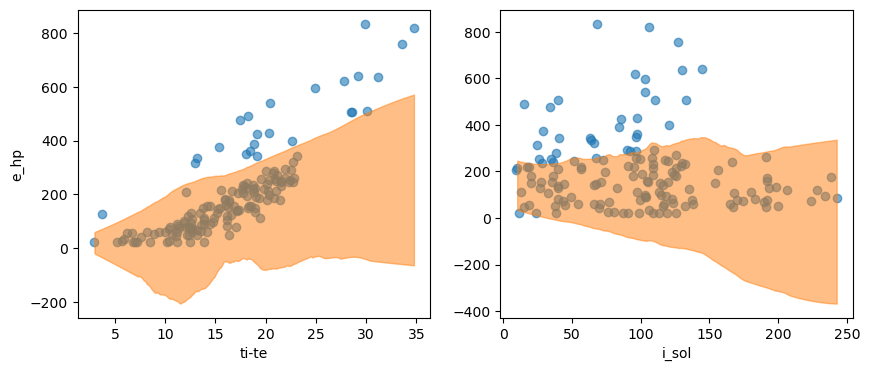

In [7]:
# The same plot as before but with the predictions drawn from the prior
yprior = priordata.prior_predictive['Y_obs']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X1, Y, alpha=0.6)
#axes[0].plot(X1, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
#axes[0].plot(X1, yprior.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1, priordata.prior_predictive["Y_obs"], ax=axes[0])
axes[0].set_xlabel("ti-te")
axes[0].set_ylabel("e_hp")

axes[1].scatter(X2, Y, alpha=0.6)
#axes[1].plot(X2, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
az.plot_hdi(X2, priordata.prior_predictive["Y_obs"], ax=axes[1])
axes[1].set_xlabel("i_sol")

The orange area shows the Highest Density Interval of the prior predictive distribution, which is the minimum width [Credible Interval](https://en.wikipedia.org/wiki/Credible_interval) of a certain probability. Ideally, most of the data should be comprised in it for the initial model to be consistent.

### Model fitting

In Bayesian terms, model "fitting" is called **conditioning** the model on the data.

In [8]:
with model1:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an InferenceData object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that sample generated a set of parallel chains, depending on how many compute cores are on your machine.

`idata` is an `InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data.

You can access the trace of one parameter from idata by uncommenting t

In [28]:
idata
#idata.posterior["alpha"]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Model checking

PyMC's plotting and diagnosis functionalities are taken care of by a dedicated package named Arviz. A simple posterior plot can be created using plot_trace:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

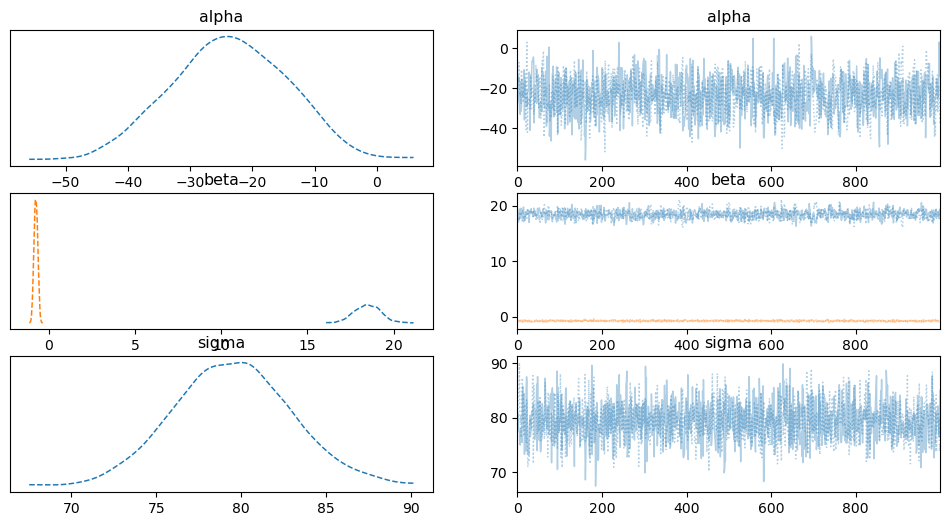

In [29]:
az.plot_trace(idata, combined=True)

In addition, the summary function provides a text-based output of common posterior statistics.

In [33]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-23.574,9.304,-39.966,-5.999,0.253,0.179,1346.0,1024.0,1.0
beta[0],18.484,0.764,16.888,19.741,0.023,0.016,1101.0,975.0,1.0
beta[1],-0.745,0.107,-0.930,-0.537,0.003,0.002,1275.0,1429.0,1.0
sigma,79.468,3.465,72.479,85.593,0.083,0.059,1734.0,1220.0,1.0


Other possible diagnosis plots:

* An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribution.
* plot_forest is designed to handle vector-valued parameters.

In [34]:
# az.plot_energy(idata)
# az.plot_forest(idata, combined=True, hdi_prob=0.95, r_hat=True);

### Posterior predictive checking

PyMC has a dedicated function to sample data from the posterior. The `extend_inferencedata=True` option allows saving posterior_prediction within the existing idata object

In [37]:
with model1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [Y_obs]


Now, the posterior_predictive group in idata contains 4000 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:

In [39]:
idata.posterior_predictive

<xarray.Dataset> Size: 2MB
Dimensions:      (chain: 2, draw: 1000, Y_obs_dim_2: 151)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 1kB 0 1 2 3 4 5 ... 145 146 147 148 149 150
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 2MB 118.8 102.9 ... -142.2
Attributes:
    created_at:                 2024-03-21T15:45:49.384021
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4

We can now reproduce the prior predictive plot from earlier, but with the posterior predictive intervals instead:

In [ ]:
_, ax = plt.subplots()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X1, Y, alpha=0.6)
#axes[0].plot(X1, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
#axes[0].plot(X1, yprior.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1, priordata.prior_predictive["Y_obs"], ax=axes[0])
axes[0].set_xlabel("ti-te")
axes[0].set_ylabel("e_hp")

axes[1].scatter(X2, Y, alpha=0.6)
#axes[1].plot(X2, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
az.plot_hdi(X2, priordata.prior_predictive["Y_obs"], ax=axes[1])
axes[1].set_xlabel("i_sol")

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])